<a href="https://colab.research.google.com/github/efeecllk/investor-sentiments/blob/main/nn_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# Cell 1: Import Libraries

import gensim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import pandas as pd


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [48]:
df = pd.read_csv('/content/drive/MyDrive/NLP/clean_tweet.csv')


In [49]:
# Her bir label değerinden 4000 örnek seç
df_label_0 = df[df['label'] == 0].sample(n=4000, random_state=42)
df_label_1 = df[df['label'] == 1].sample(n=4000, random_state=42)
df_label_2 = df[df['label'] == 2].sample(n=4000, random_state=42)

# Yeni veri çerçevesini birleştir
clean_df = pd.concat([df_label_0, df_label_1, df_label_2]).reset_index(drop=True)

# Kontrol için label dağılımını göster
print(clean_df['label'].value_counts())


label
0    4000
1    4000
2    4000
Name: count, dtype: int64


In [46]:
label_counts = clean_df['label'].value_counts()
print(label_counts)


label
2    10000
Name: count, dtype: int64


In [54]:
clean_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text_v  12000 non-null  object
 1   label   12000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 187.6+ KB


In [50]:
clean_df.head()

,text_v,label
0,financial expert predict steady increase value...,0
1,coin experiencing surge trading volume today c...,0
2,blackrock announces dividend payment dividend ...,0
3,investor urged exercise caution face market fl...,0
4,financial technology fintech rapidly transform...,0


In [3]:
word2vec_model = gensim.models.Word2Vec.load('/content/drive/MyDrive/NLP/word2vec_model.model')


In [4]:
print(word2vec_model.wv['good'] if 'good' in word2vec_model.wv else "Kelime bulunamadı")


[ 1.2065066  -1.5498743   4.3290806   1.0235827  -2.1191995  -1.91932
 -2.627178   -2.0179203   2.7778153   0.6003324  -1.7520316  -1.2726218
 -0.38420677  0.4580238  -0.74335617  2.7906876  -1.2787054   4.1497583
 -4.2355137  -0.0926513   2.2251964  -3.625772   -4.4894533  -1.553813
  1.0811808   2.416639   -0.82610786 -3.0229242  -2.5270538   1.2096163
 -2.809983   -1.0944238   0.86705756 -0.3064526   3.830741   -0.86024964
  0.6256468   2.1056542   1.5155813  -1.5912137  -1.600227   -2.2993665
  2.0102804   0.43171695  0.0521418   0.7106995  -1.5751389   2.0218503
  1.6405704   0.79498047  0.5910279  -1.612377    3.2804937   0.7853499
 -0.21600401 -3.304779   -0.56850135 -0.5327709   0.19682382  1.2346387
 -0.6314158   2.6147592   0.31772268  1.0094956   1.1704543  -0.82502985
 -3.0374503  -2.0160258   0.9556052   2.9681206   1.0318193   2.0981019
 -1.7339318  -2.8082595   1.6445243   0.28596678 -0.31484386 -0.9602643
 -2.755997   -6.159275   -0.16718331 -1.1541643  -0.9273664   0.2

In [23]:
def preprocess_text(text):
    # Ensure the input is a string
    if not isinstance(text, str):
        text = str(text)  # Convert to string if not already
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return tokens

def text_to_word2vec(text, model):
    tokens = preprocess_text(text)
    # Accessing KeyedVectors using model.wv
    word_vectors = [model.wv[word] for word in tokens if word in model.wv.key_to_index]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

In [55]:
clean_df['text_vector'] = clean_df['text_v'].apply(lambda x: text_to_word2vec(x, word2vec_model))

# Check the resulting vectors
clean_df[['text_v', 'text_vector']].head()

,text_v,text_vector
0,financial expert predict steady increase value...,"[-0.4238628, 1.3990093, -0.4794796, -1.5149565..."
1,coin experiencing surge trading volume today c...,"[-0.2896792, 1.2717527, -0.8889524, -0.7738165..."
2,blackrock announces dividend payment dividend ...,"[0.080770425, -0.027151993, 0.939373, -0.81429..."
3,investor urged exercise caution face market fl...,"[-0.2745082, 0.67496586, 1.818446, -1.5813758,..."
4,financial technology fintech rapidly transform...,"[-2.4542024, 0.48817265, -0.68885916, -0.38548..."


In [56]:
# Cell 4: Prepare Dataset for NN

# Extract features and labels
X = np.vstack(clean_df['text_vector'].values)
y = clean_df['label']

# Encode labels (Bullish=1, Bearish=2, Neutral=0)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print("Dataset prepared successfully!")
print(f"Train set shape: {X_train.shape}, Test set shape: {X_test.shape}")


Dataset prepared successfully!
Train set shape: (9600, 100), Test set shape: (2400, 100)


In [57]:
# Cell 5: Build Neural Network Model

# Define NN model
model = Sequential([
    Input(shape=(word2vec_model.vector_size,)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  # 3 classes: Bullish, Bearish, Neutral
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Display model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 128)                 │          12,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,379 (83.51 KB)

 Trainable params: 21,379 (83.51 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    verbose=1
)


Epoch 1/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8929 - loss: 0.2778 - val_accuracy: 0.8568 - val_loss: 0.3706
Epoch 2/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8889 - loss: 0.2721 - val_accuracy: 0.8505 - val_loss: 0.3835
Epoch 3/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9007 - loss: 0.2541 - val_accuracy: 0.8552 - val_loss: 0.3719
Epoch 4/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9014 - loss: 0.2656 - val_accuracy: 0.8521 - val_loss: 0.3847
Epoch 5/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8995 - loss: 0.2533 - val_accuracy: 0.8578 - val_loss: 0.3906
Epoch 6/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9080 - loss: 0.2313 - val_accuracy: 0.8469 - val_loss: 0.3989
Epoch 7/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9174 - loss: 0.2133 - val_accuracy: 0.8562 - val_loss: 0.4216
Epoch 8/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9105 - loss: 0.2139 - val_accuracy: 0.

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8644 - loss: 0.3310
Test Accuracy: 0.86


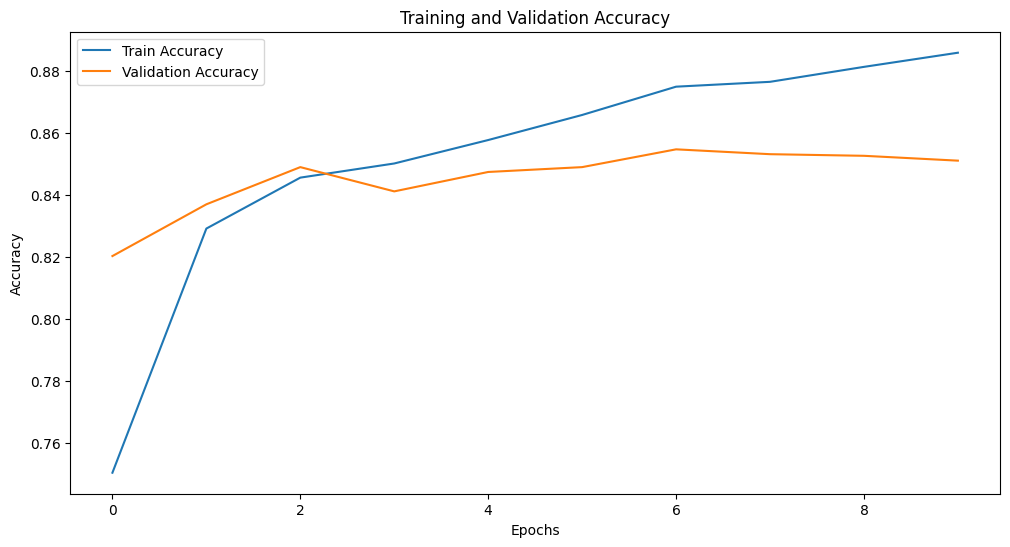

In [59]:
# Cell 7: Evaluate the Model

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [61]:
# Cell 8: Save the Trained Model

model.save('/content/drive/MyDrive/NLP/sentiment_nn_model.h5')
print("✅ Neural Network Sentiment Model saved successfully!")


✅ Neural Network Sentiment Model saved successfully!
